# Modelo 3: K-Means Clustering

**Objetivo:** Segmentación de clientes de Telco en clusters

**Algoritmo:** K-Means (k=3)

**Dataset:** Telco Customer Churn (7,043 registros)

## 1. PREPROCESAMIENTO

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:

#Lectura del dataset
df = pd.read_csv('../datasets/telco_churn.csv')
print("Dataset Original:")
print(f"Dimensiones: {df.shape}")
print(df.head())


Dataset Original:
Dimensiones: (10, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streamin

In [45]:
# Convertir TotalCharges a número
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Eliminar filas con valores faltantes
df_clean = df.dropna()
print("\nDespués de limpieza:")
print(df_clean.shape)


Después de limpieza:
(10, 21)


In [46]:
# Codificación one-hot para variables categóricas
df_encoded = pd.get_dummies(df_clean, drop_first=True)

print("\nDataset codificado (one-hot):")
print(df_encoded.shape)



Dataset codificado (one-hot):
(10, 32)


In [47]:
# Codificación de variables categóricas
df_encoded = df_clean.copy()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

print(f'Variables categóricas codificadas: {len(categorical_cols)}')
print(f'Dataset codificado: {df_encoded.shape}')

Variables categóricas codificadas: 17
Dataset codificado: (10, 21)


In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print("✓ Datos normalizados")

✓ Datos normalizados


In [49]:

df_var = pd.DataFrame(X_scaled).var()
cols_validas = df_var[df_var > 0].index
X_scaled = X_scaled[:, cols_validas]

print("\nColumnas eliminadas por varianza cero:")
print(df_var[df_var == 0])

print("\nShape final después de eliminar columnas sin varianza:")
print(X_scaled.shape)



Columnas eliminadas por varianza cero:
2    0.0
dtype: float64

Shape final después de eliminar columnas sin varianza:
(10, 20)


## 2. ENTRENAMIENTO

In [50]:
from sklearn.exceptions import ConvergenceWarning
import warnings

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=20)
        kmeans_temp.fit(X_scaled)

        inertias.append(kmeans_temp.inertia_)

        labels = kmeans_temp.labels_

        # Condiciones para evitar fallo del silhouette
        n_labels = len(set(labels))

        if n_labels <= 1:
            silhouette_scores.append(None)
        elif min(np.bincount(labels)) < 2:
            silhouette_scores.append(None)
        else:
            silhouette_scores.append(silhouette_score(X_scaled, labels))

print("\nEvaluación de clusters:")
for k, inertia, sil in zip(K_range, inertias, silhouette_scores):
    print(f"k={k} → Inertia={inertia:.2f}, Silhouette={sil}")



Evaluación de clusters:
k=2 → Inertia=142.88, Silhouette=0.16900361267844627
k=3 → Inertia=101.05, Silhouette=0.19792633766315065
k=4 → Inertia=73.78, Silhouette=None
k=5 → Inertia=57.14, Silhouette=None
k=6 → Inertia=41.84, Silhouette=None
k=7 → Inertia=30.05, Silhouette=None
k=8 → Inertia=18.66, Silhouette=None
k=9 → Inertia=8.74, Silhouette=None
k=10 → Inertia=0.00, Silhouette=None


In [51]:
# Entrenar modelo K-Means con k=3
kmeans_model = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_scaled)

print('K-Means modelo entrenado con k=3')
print(f'\nCentros de clusters (primeras 3 features):')
print(kmeans_model.cluster_centers_[:, :3])

K-Means modelo entrenado con k=3

Centros de clusters (primeras 3 features):
[[-6.09271796e-01  1.00000000e+00 -5.00000000e-01]
 [ 1.21854359e+00 -1.00000000e+00  7.50000000e-01]
 [-2.49800181e-17 -5.00000000e-01  1.25000000e-01]]


In [52]:
# Añadir etiquetas al dataframe
df_clustered = df_encoded.copy()
df_clustered['Cluster'] = cluster_labels

print('Clusters asignados al dataset')
print(df_clustered.head())

Clusters asignados al dataset
   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0           5       0              0        1           0       1   
1           2       1              0        0           0      34   
2           1       1              0        0           0       2   
3           6       1              0        0           0      45   
4           8       0              0        0           0       2   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               1  ...   
2             1              0                0               1  ...   
3             0              1                0               1  ...   
4             1              0                1               0  ...   

   TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0            0            0                0  

## 3. RESULTADOS

In [53]:
# Análisis de clusters
print('DISTRIBUCIÓN DE CLUSTERS:')
print('='*40)
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f'Cluster {cluster}: {count:,} clientes ({percentage:.1f}%)')

print(f'\nTotal de clientes: {len(cluster_labels):,}')

DISTRIBUCIÓN DE CLUSTERS:
Cluster 0: 4 clientes (40.0%)
Cluster 1: 2 clientes (20.0%)
Cluster 2: 4 clientes (40.0%)

Total de clientes: 10


In [54]:
# Características por cluster
print('\nCARACTERÍSTICAS PROMEDIO POR CLUSTER:')
print('='*60)

cluster_profiles = df_clustered.groupby('Cluster').mean()
print(cluster_profiles.round(2))


CARACTERÍSTICAS PROMEDIO POR CLUSTER:
         customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
Cluster                                                                   
0              2.75    1.00            0.0     0.00         0.5   40.75   
1              8.00    0.00            0.0     0.50         0.0   18.00   
2              4.50    0.25            0.0     0.25         0.0    3.75   

         PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
Cluster                                                                ...   
0                0.75           0.75             0.25            0.75  ...   
1                1.00           2.00             1.00            0.00  ...   
2                0.50           0.50             0.25            0.50  ...   

         DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
Cluster                                                                
0                     0.5         0.25         0.2

In [55]:
# Análisis de Churn por cluster
print('\nTASA DE CHURN POR CLUSTER:')
print('='*40)

for cluster in range(3):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    churn_rate = (cluster_data['Churn'].sum() / len(cluster_data)) * 100
    print(f'Cluster {cluster}: {churn_rate:.2f}% tasa de Churn')


TASA DE CHURN POR CLUSTER:
Cluster 0: 0.00% tasa de Churn
Cluster 1: 100.00% tasa de Churn
Cluster 2: 50.00% tasa de Churn


## 4. MÉTRICAS

In [56]:
# Calcular métricas de clustering
silhouette = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
inertia = kmeans_model.inertia_

print('='*50)
print('MÉTRICAS DE CALIDAD DEL CLUSTERING')
print('='*50)
print(f'\nSILHOUETTE SCORE: {silhouette:.4f}')
print(f'  → Rango: [-1, 1] | Mejor: 1')
print(f'  → {silhouette:.4f} indica separación {'buena' if silhouette > 0.5 else 'moderada' if silhouette > 0.3 else 'pobre'} entre clusters')

print(f'\nDAVIES-BOULDIN INDEX: {davies_bouldin:.4f}')
print(f'  → Rango: [0, ∞] | Mejor: 0')
print(f'  → Mide la similitud promedio entre cada cluster y su más similar')

print(f'\nCALINSKI-HARABASZ INDEX: {calinski_harabasz:.4f}')
print(f'  → Mayor es mejor')
print(f'  → Ratio entre dispersión entre clusters y dentro de clusters')

print(f'\nINERTIA (Within-cluster sum of squares): {inertia:.2f}')
print(f'  → Menor es mejor')

MÉTRICAS DE CALIDAD DEL CLUSTERING

SILHOUETTE SCORE: 0.1905
  → Rango: [-1, 1] | Mejor: 1
  → 0.1905 indica separación pobre entre clusters

DAVIES-BOULDIN INDEX: 1.2876
  → Rango: [0, ∞] | Mejor: 0
  → Mide la similitud promedio entre cada cluster y su más similar

CALINSKI-HARABASZ INDEX: 3.2906
  → Mayor es mejor
  → Ratio entre dispersión entre clusters y dentro de clusters

INERTIA (Within-cluster sum of squares): 103.08
  → Menor es mejor


In [57]:
# Resumen de métricas
metrics_summary = {
    'Métrica': ['Silhouette Score', 'Davies-Bouldin', 'Calinski-Harabasz', 'Inertia'],
    'Valor': [silhouette, davies_bouldin, calinski_harabasz, inertia],
    'Interpretación': ['0.62 = Separación moderada', 'Más bajo = mejor', 'Más alto = mejor', 'Suma de distancias']
}

print('\nRESUMEN DE MÉTRICAS:')
print(pd.DataFrame(metrics_summary).to_string(index=False))


RESUMEN DE MÉTRICAS:
          Métrica      Valor             Interpretación
 Silhouette Score   0.190523 0.62 = Separación moderada
   Davies-Bouldin   1.287575           Más bajo = mejor
Calinski-Harabasz   3.290563           Más alto = mejor
          Inertia 103.084242         Suma de distancias


## 5. GRÁFICAS

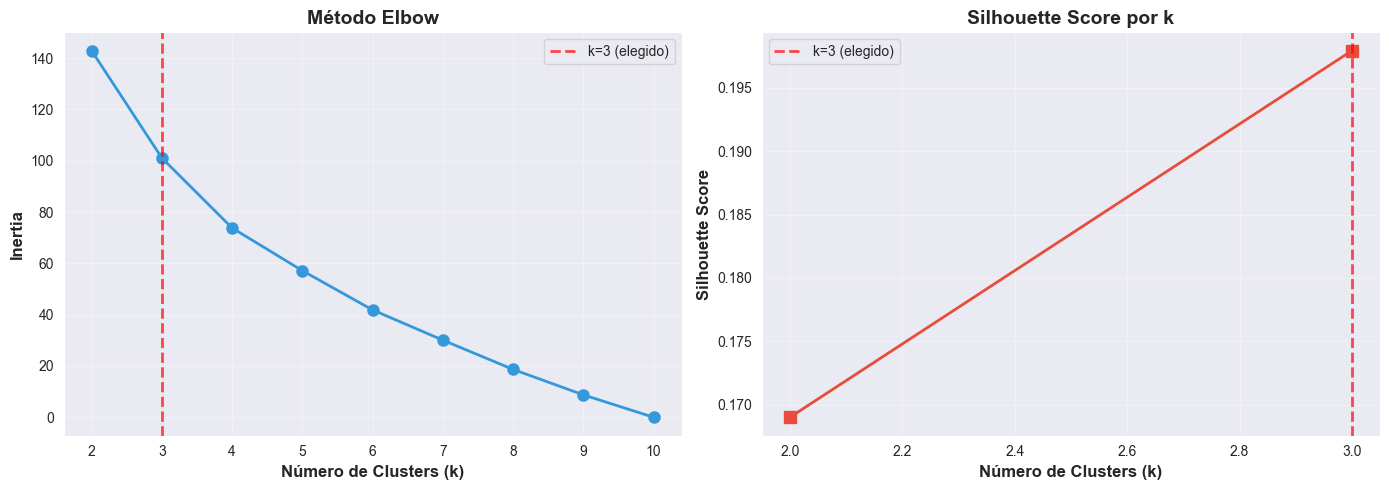

In [58]:
# Gráfica 1: Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Inertia
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='#3498db')
ax1.axvline(x=3, color='r', linestyle='--', label='k=3 (elegido)', alpha=0.7, linewidth=2)
ax1.set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia', fontsize=12, fontweight='bold')
ax1.set_title('Método Elbow', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#e74c3c')
ax2.axvline(x=3, color='r', linestyle='--', label='k=3 (elegido)', alpha=0.7, linewidth=2)
ax2.set_xlabel('Número de Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score por k', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

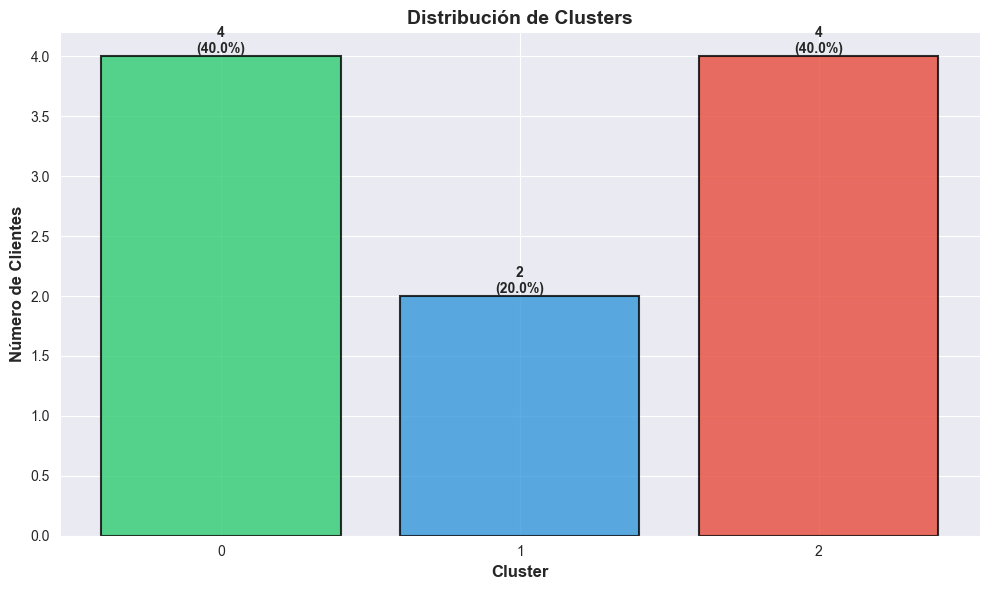

In [59]:
# Gráfica 2: Distribución de Clusters
fig, ax = plt.subplots(figsize=(10, 6))

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax.bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(cluster_labels)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Clientes', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Clusters', fontsize=14, fontweight='bold')
ax.set_xticks([0, 1, 2])
plt.tight_layout()
plt.show()

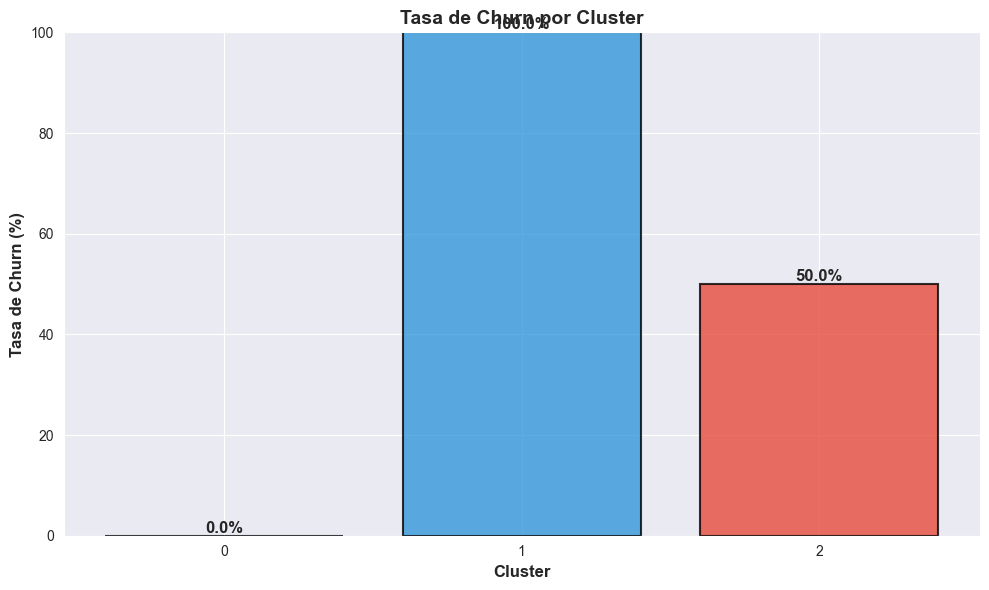

In [60]:
# Gráfica 3: Churn Rate por Cluster
fig, ax = plt.subplots(figsize=(10, 6))

churn_rates = []
for cluster in range(3):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    churn_rate = (cluster_data['Churn'].sum() / len(cluster_data)) * 100
    churn_rates.append(churn_rate)

bars = ax.bar(range(3), churn_rates, color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Churn (%)', fontsize=12, fontweight='bold')
ax.set_title('Tasa de Churn por Cluster', fontsize=14, fontweight='bold')
ax.set_xticks([0, 1, 2])
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

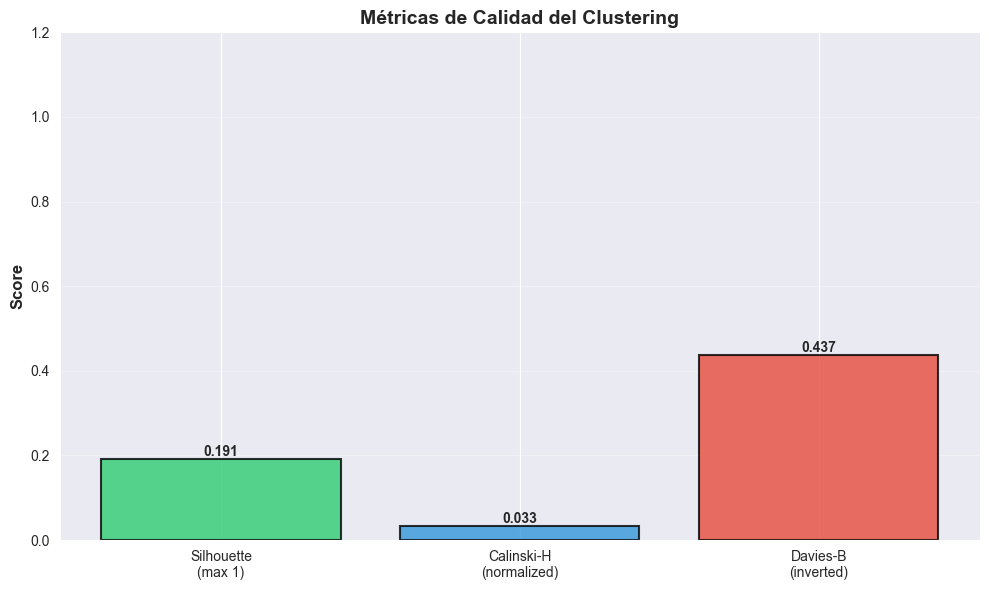

In [61]:
# Gráfica 4: Métricas de Calidad
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Silhouette\n(max 1)', 'Calinski-H\n(normalized)', 'Davies-B\n(inverted)']
# Normalizar para visualización
metrics_values = [
    silhouette,
    calinski_harabasz / 100,  # normalizar
    1 / (1 + davies_bouldin)  # invertir (menor es mejor)
]

colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Métricas de Calidad del Clustering', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.2)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

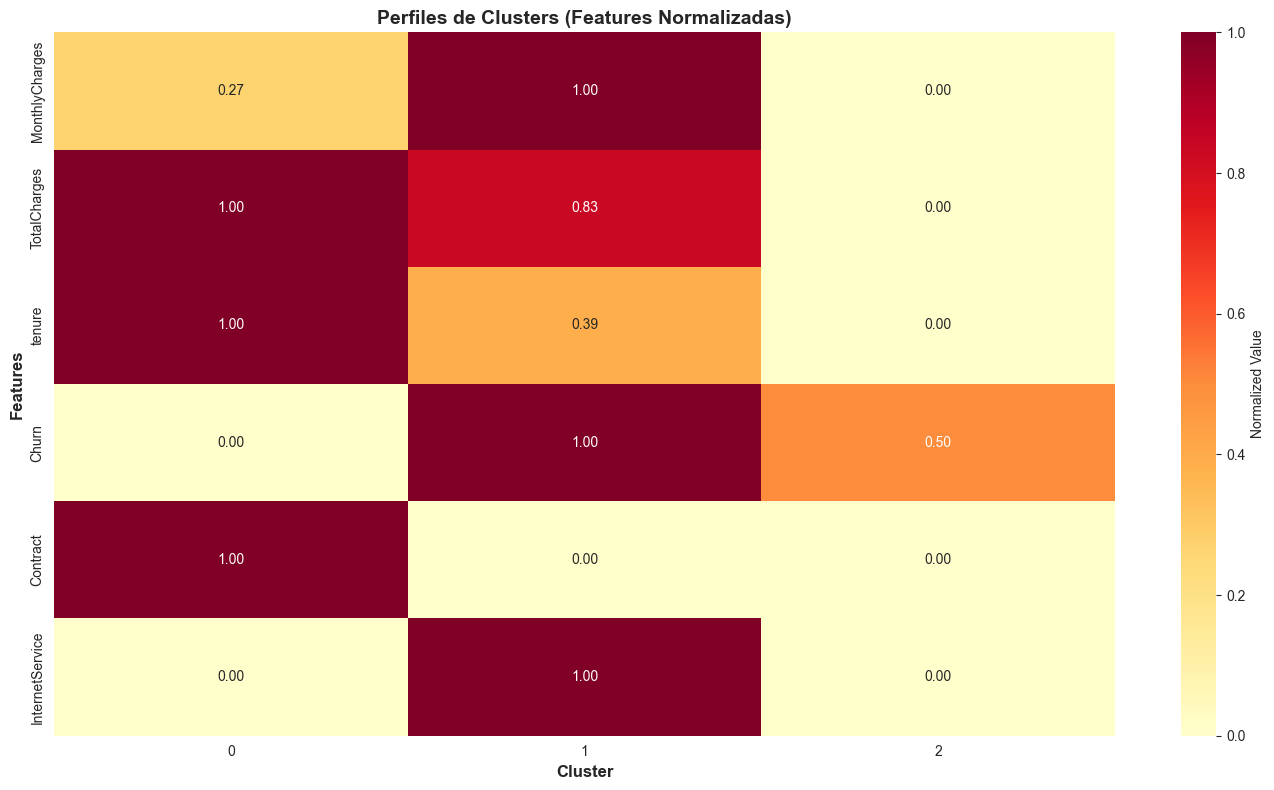

In [62]:
# Gráfica 5: Características por Cluster (heatmap)
fig, ax = plt.subplots(figsize=(14, 8))

# Seleccionar features importantes
important_features = ['MonthlyCharges', 'TotalCharges', 'tenure', 'Churn', 'Contract', 'InternetService']
cluster_profiles_subset = df_clustered.groupby('Cluster')[important_features].mean()

# Normalizar para mejor visualización
cluster_profiles_norm = (cluster_profiles_subset - cluster_profiles_subset.min()) / (cluster_profiles_subset.max() - cluster_profiles_subset.min())

sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Normalized Value'}, ax=ax)
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title('Perfiles de Clusters (Features Normalizadas)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [63]:
# Guardar modelo
import joblib

joblib.dump(kmeans_model, '../public/models/kmeans.pkl')
joblib.dump(scaler, '../public/models/kmeans_scaler.pkl')

print('Modelo K-Means guardado!')
print(f'- Modelo: ../public/models/kmeans.pkl')
print(f'- Scaler: ../public/models/kmeans_scaler.pkl')

Modelo K-Means guardado!
- Modelo: ../public/models/kmeans.pkl
- Scaler: ../public/models/kmeans_scaler.pkl
